<a href="https://colab.research.google.com/github/joshua-meppiel/dl-workshop-2022/blob/main/Build_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPSCI 5390 - Semester Project - Task 1

The objective in this task is to design a convolutional neural network (not feed-forward neural network) to overfit your dataset.


[Requirement for graduate students only] If you provide the output as the input (as an additional channel), what is the smallest architecture (minimum number of layers and filters) you need to overfit the data? Discuss this in your report and submit your notebook. Here is an example code that shows you how to add the output as an additional input channel.

<< It doesn't seem like this is looping the network back on itself, instead it just means supplying the labels along with the normal inputs>>

# Imports and copy data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os

data_dir = pathlib.Path('/home/josh/data/asl/train')
test_data_dir = pathlib.Path('/home/josh/data/asl/test/')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2023-04-10 14:23:01.555872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 14:23:02.101054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


87000


# Check versions and devices

In [2]:
print(f"TensorFlow version: ", tf.__version__)
print(f"Numpy version: ", np.__version__)

print(f"Available CPU(s): ", len(tf.config.list_physical_devices('CPU')))
print(f"Available GPU(s): ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.12.0
Numpy version:  1.23.5
Available CPU(s):  1
Available GPU(s):  1


2023-04-10 14:23:03.436224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 14:23:03.538288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 14:23:03.538339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


# Load data into traning and validation sets

In [3]:
batch_size = 48
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0,  # set to 0 to NOT split the data for task #1
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)
print(len(class_names))

Found 87000 files belonging to 29 classes.


2023-04-10 14:23:06.176965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 14:23:06.177040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 14:23:06.177069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 14:23:07.257595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 14:23:07.257692: I tensorflow/compile

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [4]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


# Test display an image

2023-04-10 14:23:09.829654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [87000]
	 [[{{node Placeholder/_4}}]]
2023-04-10 14:23:09.829880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [87000]
	 [[{{node Placeholder/_0}}]]


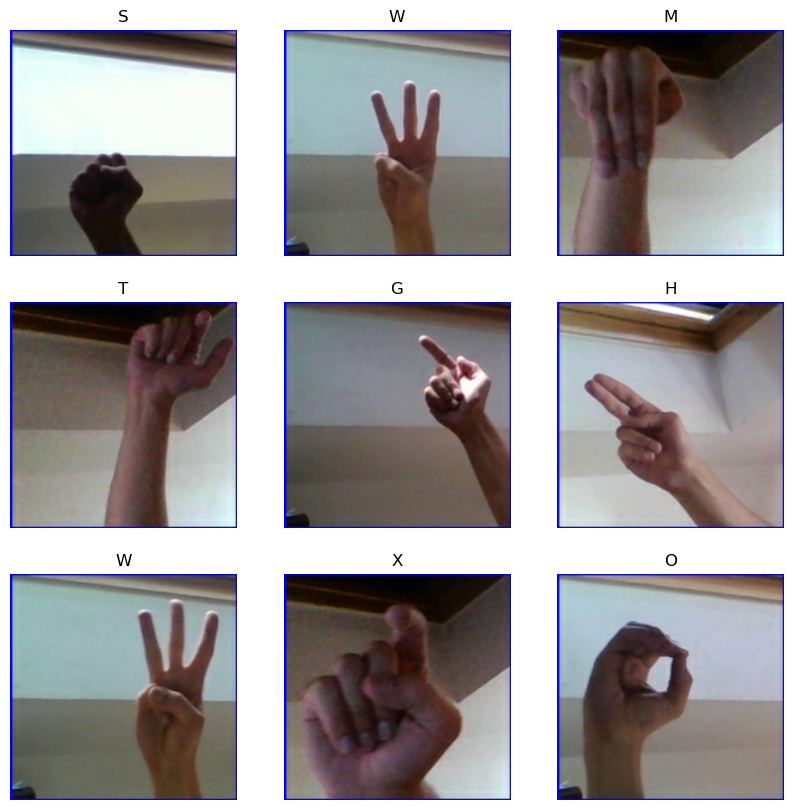

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Test Image Formats

In [6]:
import imghdr
from pathlib import Path

bad_image_counter = 0

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_image_counter += 1
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_image_counter +=1
            os.remove(filepath)


print(f"bad_image_counter: {bad_image_counter}")

bad_image_counter: 0


# Create the model

In [7]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(width_factor=0.1,height_factor=0.1)
  ]
)

"""
model = tf.keras.Sequential([
  #data_augmentation,
  tf.keras.layers.Rescaling(1./255),

  #tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=('tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)', 'tf.Tensor(shape=(None,), dtype=int32)')),

  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(42, activation='relu'),
  tf.keras.layers.Dense(num_classes),
  tf.keras.layers.Softmax()
])
"""



inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(42, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Add output labels as inputs

In [8]:
"""
# Extract labels from the dataset
train_labels = []
for images, labels in train_ds:
  train_labels.append(labels.numpy())

# Flatten the labels list
train_labels = [item for sublist in train_labels for item in sublist]

# Create input-output pairs
train_data = [(images, labels) for images, labels in zip(train_ds, train_labels)]
"""

'\n# Extract labels from the dataset\ntrain_labels = []\nfor images, labels in train_ds:\n  train_labels.append(labels.numpy())\n\n# Flatten the labels list\ntrain_labels = [item for sublist in train_labels for item in sublist]\n\n# Create input-output pairs\ntrain_data = [(images, labels) for images, labels in zip(train_ds, train_labels)]\n'

# Compile and Train the Model

In [9]:
optimizer = tf.keras.optimizers.Adam()
model.compile(  optimizer=optimizer,  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  metrics=['accuracy'])

#history = model.fit( train_ds, validation_data=train_ds, epochs=5 )
#history = model.fit( train_data, epochs=2 )

#for images, labels in train_ds:
    #history = model.fit(images,labels,epochs=1)

images, labels = next(iter(train_ds))
val_images, val_labels = next(iter(train_ds.take(1).repeat()))

history = model.fit(x=images, y=labels, epochs=10)
#history = model.fit(x=(images, labels), y=labels, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10


2023-04-10 14:23:13.104630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [87000]
	 [[{{node Placeholder/_0}}]]
2023-04-10 14:23:13.104965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [87000]
	 [[{{node Placeholder/_0}}]]
2023-04-10 14:23:13.185166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [87

TypeError: in user code:

    File "/home/josh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/josh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/josh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/josh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/josh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer 'rescaling' (type Rescaling).
    
    Cannot convert a list containing a tensor of dtype <dtype: 'int32'> to <dtype: 'float32'> (Tensor is: <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int32>)
    
    Call arguments received by layer 'rescaling' (type Rescaling):
      • inputs=('tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)', 'tf.Tensor(shape=(None,), dtype=int32)')


In [ ]:
print(history.history.keys()) # ['accuracy', 'loss']

# Display the model structure

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Investigate Learning Curves

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss']) # replace with accuracy/MAE
plt.plot(history.history['val_loss']) # replace with val_accuracy, etc.
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='upper right')

plt.show()

# Validation Data Set

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_ds, verbose=2)

# Try to pull some of the weights out of the model

In [ ]:
"""
import seaborn as sns

filter_weights = model.get_weights()
print(filter_weights.shape)
import seaborn as sns
sns.heatmap(filter_weights[:,:, 0,0], cmap = 'Reds')
plt.show()


for x in filter_weights:
    print(x)
    sns.heatmap(x[:,:, 0,0], cmap = 'Reds')
    plt.show()
"""

# What is the model predicting?

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=None,
  subset=None,
  seed=None,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False
)

valid_loss, valid_acc = model.evaluate(test_ds, verbose=2)
test_class_names = test_ds.class_names
test_ds_instance = test_ds.take(1)

plt.figure(figsize=(15, 15))
for images, labels in test_ds_instance:
  for i in range(29):
    x = np.expand_dims(images[i], axis=0)
    p = model.predict(x, verbose=0)    
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]] + ":" + class_names[p.argmax()])
    plt.axis("off")